In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import elettrocablaggi


from mrcnn import visualize
from mrcnn import utils
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import mrcnn.model as modellib

Using TensorFlow backend.


### Dataset location info

In [2]:
info = {'train': {'label_file_path':"../../dataset/elettrocablaggi_20200921/train/annots/labels.txt",
                   'annotation_dir': "../../dataset/elettrocablaggi_20200921/train/annots/",
                   'images_dir': "../../dataset/elettrocablaggi_20200921/train/images/"},
         'test':{'label_file_path':"../../dataset/elettrocablaggi_20200921/test/annots/labels.txt",
                   'annotation_dir': "../../dataset/elettrocablaggi_20200921/test/annots/",
                   'images_dir': "../../dataset/elettrocablaggi_20200921/test/images/"},
         'saved_model_dir': "../../weights/elettrocablaggi_20200921/"}

### Load training and test set

In [3]:
# Training dataset
dataset_train = elettrocablaggi.ElettrocablaggiDataset()
class_info, train_image_info = dataset_train.load_elettrocablaggi(info['train']['label_file_path'], 
                                                                  info['train']['annotation_dir'], 
                                                                  info['train']['images_dir'])
dataset_train.prepare()

# Validation dataset
dataset_val = elettrocablaggi.ElettrocablaggiDataset()
class_info, val_image_info = dataset_val.load_elettrocablaggi(info['test']['label_file_path'], 
                                                              info['test']['annotation_dir'], 
                                                              info['test']['images_dir'])
dataset_val.prepare()

print("Training set: ", len(train_image_info))
print("Test set: ", len(val_image_info))
print("Class info:", class_info)

Training set:  5
Test set:  6
Class info: [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'elettrocablaggi', 'id': 0, 'name': '0'}, {'source': 'elettrocablaggi', 'id': 1, 'name': '1'}, {'source': 'elettrocablaggi', 'id': 2, 'name': '2'}, {'source': 'elettrocablaggi', 'id': 3, 'name': '3'}, {'source': 'elettrocablaggi', 'id': 4, 'name': '4'}, {'source': 'elettrocablaggi', 'id': 5, 'name': '5'}, {'source': 'elettrocablaggi', 'id': 6, 'name': '6'}, {'source': 'elettrocablaggi', 'id': 7, 'name': '7'}, {'source': 'elettrocablaggi', 'id': 8, 'name': '8'}, {'source': 'elettrocablaggi', 'id': 9, 'name': '9'}, {'source': 'elettrocablaggi', 'id': 10, 'name': '10'}, {'source': 'elettrocablaggi', 'id': 11, 'name': '11'}, {'source': 'elettrocablaggi', 'id': 12, 'name': '12'}, {'source': 'elettrocablaggi', 'id': 13, 'name': '13'}, {'source': 'elettrocablaggi', 'id': 14, 'name': '14'}, {'source': 'elettrocablaggi', 'id': 15, 'name': '15'}, {'source': 'elettrocablaggi', 'id': 16, 'name': '16'}, {'s

### Display random samples for training e validation set

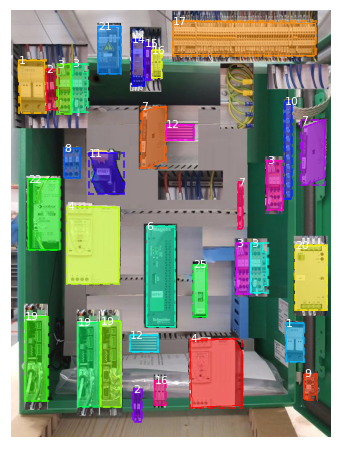

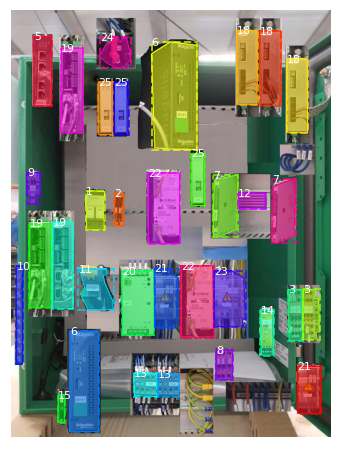

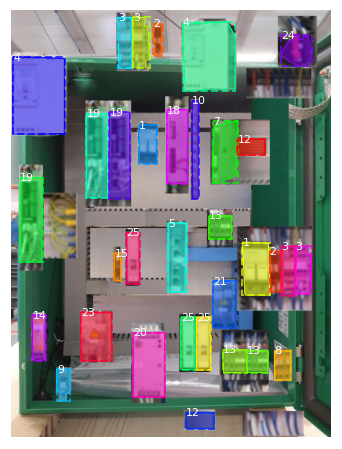

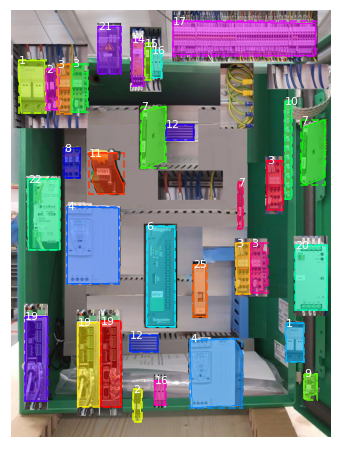

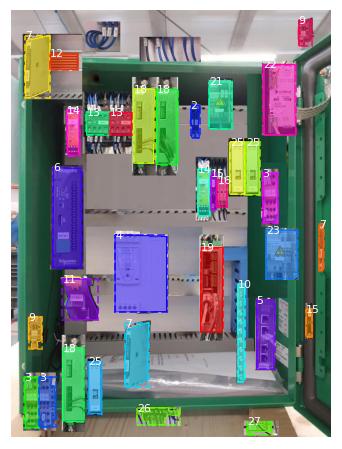

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
# image_ids = [i for i in range(1)]
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_instances(image, utils.extract_bboxes(mask), mask, class_ids, 
                            dataset_train.class_names, figsize=(8, 8))

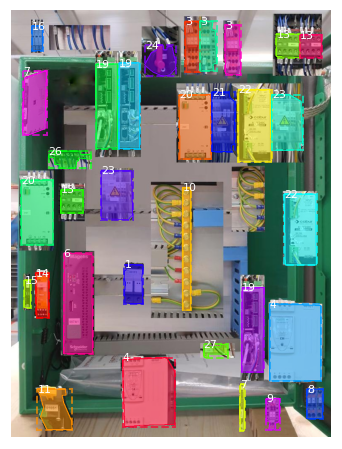

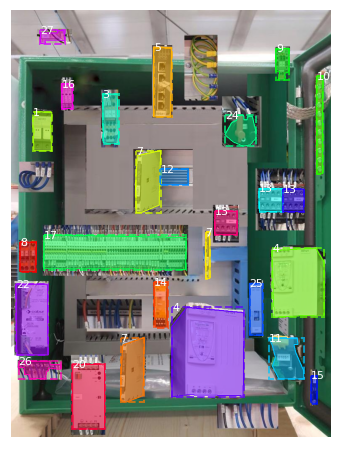

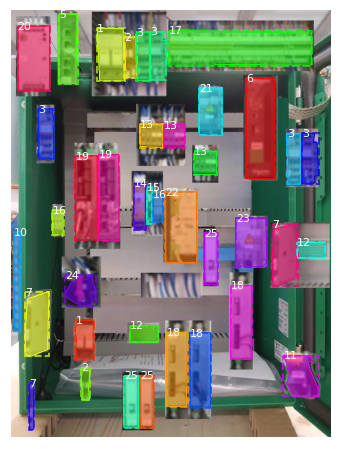

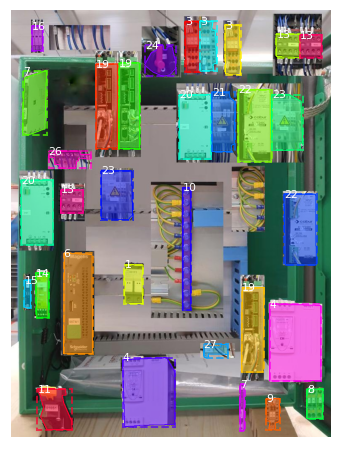

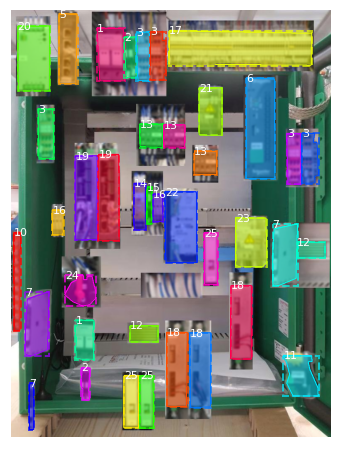

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 5)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_instances(image, utils.extract_bboxes(mask), mask, class_ids, 
                            dataset_val.class_names, figsize=(8, 8))

### Diplay model config for training

In [6]:
# Create config class containing training properties
config = elettrocablaggi.ElettrocablaggiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

### Load trainend weight

In [7]:
inference_config = elettrocablaggi.ElettrocablaggiInferenceConfig()

# create the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=info['saved_model_dir'])

# Get path of saved weights
model_path = model.find_last()
prediction_dir = '/'.join(model_path.split('/')[:-1])
print("Directory of infered images: ", prediction_dir)







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Directory of infered images:  ../../weights/elettrocablaggi_20200921


### Display prediction

In [8]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return fig, ax


In [9]:
images = glob.glob(os.path.join(prediction_dir, 'elettrocablaggi20201224T2241','prediction', '*.jpg'))
print(images)

['../../weights/elettrocablaggi_20200921\\elettrocablaggi20201224T2241\\prediction\\20200921_101722.jpg']


In [10]:
samples = 1
random = True
replace = False

if random:
    image_ids = np.random.choice(len(images), samples, replace=replace)
else:
    image_ids = images

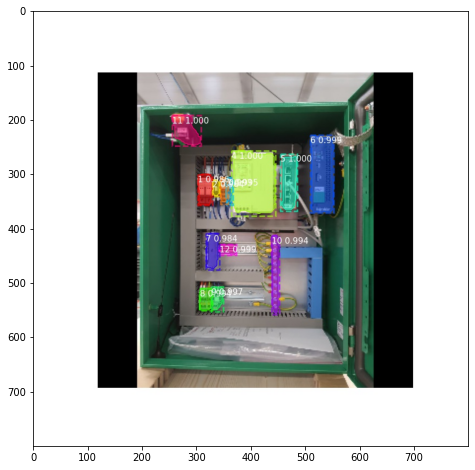

In [11]:
for i in image_ids:
    img = mpimg.imread(images[i])
    fig, ax = get_ax()
    imgplot = ax.imshow(img)

### Tensorboard

In [12]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir model_path

### Analysis of DLV output file

#### Import libraries for graph analisys

In [1]:
import os
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

#### Load files

In [7]:
image_name = '20200921_101722.jpg'

resoner_dir = os.path.join("..","..","reasoner")
graph_dir = os.path.join(resoner_dir, "graph")
net_dir = os.path.join(resoner_dir, "net")
cad_dir = os.path.join(resoner_dir, "cad")

facts_net = os.path.join(net_dir, "facts_{}.asp".format(image_name[:-4]))
ouput_net = os.path.join(net_dir, "output_{}.asp".format(image_name[:-4]))

facts_cad = os.path.join(cad_dir, "facts_GRETA230V.asp")
output_cad = os.path.join(cad_dir, "output_GRETA230V.asp")

#### Definizione delle funzioni utilizzate di seguito

In [3]:
def parser_component(facts):
    """Parsificatore del file di fatti ASP.
       Return:
           - component, lista contentente [label, id, x1, y1, x2, y2, x3, y3, x4, y4]
    """
    component = []
    with open(facts, 'r') as f:
        for i, line in enumerate(f):
            cmp = line.split('(')[1].split(')')[0].split(',')
            component.append([cmp[0].replace('\"', ''), int(cmp[1]),
                              int(cmp[2]), int(cmp[3]),
                              int(cmp[4]), int(cmp[5]),
                              int(cmp[6]), int(cmp[7]),
                              int(cmp[8]), int(cmp[9]),
                              ])
    return component


def parser_neighbour(output, flag_img=False, flag_cad=False):
    """Parsificatore del file di output ASP.
       Return:
           - neighbours, lista contenente [label_1, id_1, label_2, id_2, position]
    """
    with open(output, 'r') as f:
        for i, line in enumerate(f):
            if i >= 2:
                neighbours = [e for e in re.findall('\((.*?)\)', line)]

    tmp = []
    for e in neighbours:
        tmp.append(e.split(','))

    neighbour = []
    for row in tmp:
        for col in row:
            if flag_img and (col == 'left' or col == 'bottom'):
                row[0] = row[0].replace('\"', '')
                row[1] = int(row[1])
                row[2] = row[2].replace('\"', '')
                row[3] = int(row[3])
                if col == 'bottom':
                    row[4] = 'top'
                neighbour.append(row)
            if flag_cad and (col == 'left' or col == 'top'):
                row[0] = row[0].replace('\"', '')
                row[1] = int(row[1])
                row[2] = row[2].replace('\"', '')
                row[3] = int(row[3])
                neighbour.append(row)
    return neighbour


def checkNodeClass(green, yellow, red, max_score):
    """Funzione per verificare che ad un nodo del grafo non sia stata assegnata più di una classe
       NOTA:
           - green -> OK
           - yellow -> Forse
           - red -> NO
    """
    for key in max_score:
        for k in max_score:
            if max_score[key][0] == max_score[k][0] and max_score[key][1] > max_score[k][1]:
                del max_score[k]
                green.remove(k)

    vs_12 = [v for v in yellow if (v in green)]
    vs_13 = [v for v in red if (v in green)]
    vs_23 = [v for v in red if (v in yellow)]
    if vs_12:
        for v in vs_12:
            yellow.remove(v)
    if vs_13:
        for v in vs_13:
            red.remove(v)
    if vs_23:
        for v in vs_23:
            red.remove(v)
    return yellow, red


def removeDuplicates(lst):
    return list(set([i for i in lst]))

#### Rappresentazione grafo delle componenti riconosciute sull'immagine

{1: Text(0.0, 1.0, '11'),
 2: Text(0.4945454545454546, 0.6880466472303208, '4'),
 3: Text(0.7563636363636363, 0.6938775510204083, '5'),
 4: Text(1.0, 0.7434402332361516, '6'),
 5: Text(0.30545454545454553, 0.29446064139941686, '12'),
 6: Text(0.22909090909090912, 0.00291545189504383, '9'),
 7: Text(0.32000000000000006, 0.6413994169096211, '3'),
 8: Text(0.6581818181818182, 0.14577259475218662, '10'),
 9: Text(0.1454545454545455, 0.0, '8'),
 10: Text(0.28, 0.6443148688046647, '3'),
 11: Text(0.13818181818181818, 0.6501457725947521, '1'),
 12: Text(0.19272727272727275, 0.282798833819242, '7'),
 13: Text(0.21818181818181825, 0.6618075801749272, '2')}

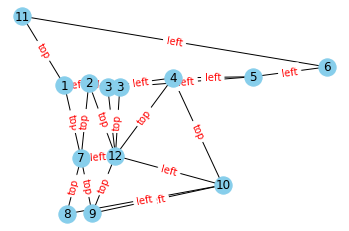

In [8]:
comp_net = parser_component(facts_net)
neig_net = parser_neighbour(ouput_net, flag_img=True)

G_net = nx.Graph()

nodes_net = [i + 1 for i in range(len(comp_net))]
edge = [(lst[1], lst[3]) for lst in neig_net]

G_net.add_nodes_from(nodes_net)
G_net.add_edges_from(edge)

mapping_net = {}
for e in comp_net:
    mapping_net[e[1]] = e[0]

# coordinates for all nodes
xy = np.zeros([len(comp_net), 2])
for i, row in enumerate(comp_net):
    xy[i, 0] = (comp_net[i][2] + comp_net[i][4] + comp_net[i][6] + comp_net[i][8]) / 2
    xy[i, 1] = (comp_net[i][3] + comp_net[i][5] + comp_net[i][7] + comp_net[i][9]) / 2
min_max_scaler = preprocessing.MinMaxScaler()
xy = min_max_scaler.fit_transform(xy)
for i, row in enumerate(xy):
    xy[i, 1] = 1 - xy[i, 1]

# position for all nodes
pos_net = {}
for i, e in enumerate(comp_net):
    pos_net[e[1]] = xy[i, :]

edge_labels_net = {}
for e in neig_net:
    edge_labels_net[e[1], e[3]] = e[4]

nx.draw_networkx_edge_labels(G_net, pos_net, edge_labels=edge_labels_net, font_color='red')

# draw the graph
nx.draw(G_net, pos_net, node_color='skyblue')
nx.draw_networkx_labels(G_net, pos_net, mapping_net)

#### Rappresentazione grafo delle componenti riconosciute sul CAD

{(11, 5): Text(0.21136521136521136, 0.7396892710828393, 'left'),
 (11, 4): Text(0.155925155925156, 0.7396892710828393, 'left'),
 (6, 4): Text(0.10202510202510207, 0.7370976819675136, 'left'),
 (5, 2): Text(0.42590667590667586, 0.7415740631667126, 'left'),
 (4, 2): Text(0.3704666204666205, 0.7415740631667126, 'left'),
 (2, 3): Text(0.6610456610456611, 0.7434588552505859, 'left'),
 (6, 5): Text(0.15746515746515743, 0.7370976819675136, 'left'),
 (10, 12): Text(0.08555671055671066, 0.0013154278085365234, 'left'),
 (3, 7): Text(0.8926041426041428, 0.7198989542021702, 'left'),
 (8, 10): Text(0.06347693847693858, 0.15445478462323792, 'top'),
 (6, 9): Text(0.02415877415877421, 0.5217078310493318, 'top'),
 (9, 10): Text(0.03768191268191279, 0.15445478462323792, 'top'),
 (11, 8): Text(0.10385385385385393, 0.5242994201646576, 'top'),
 (8, 12): Text(0.12198737198737208, 0.15577021243177444, 'top'),
 (1, 5): Text(0.30270655270655267, 0.8698446355414197, 'top'),
 (1, 4): Text(0.2472664972664973, 0.8

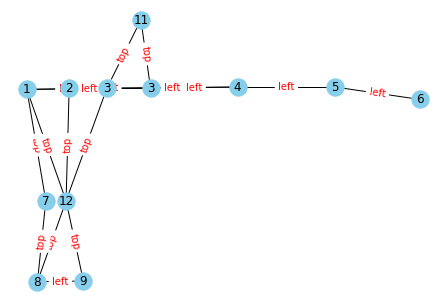

In [9]:
comp_cad = parser_component(facts_cad)
neig_cad = parser_neighbour(output_cad, flag_cad=True)

G_cad = nx.Graph()

nodes_cad = [i + 1 for i in range(len(comp_cad))]
edge = [(lst[1], lst[3]) for lst in neig_cad]

G_cad.add_nodes_from(nodes_cad)
G_cad.add_edges_from(edge)

mapping_cad = {}
for e in comp_cad:
    mapping_cad[e[1]] = e[0]

# coordinates for all nodes
xy = np.zeros([len(comp_cad), 2])
for i, row in enumerate(comp_cad):
    xy[i, 0] = (comp_cad[i][2] + comp_cad[i][4] + comp_cad[i][6] + comp_cad[i][8]) / 4
    xy[i, 1] = (comp_cad[i][3] + comp_cad[i][5] + comp_cad[i][7] + comp_cad[i][9]) / 4
min_max_scaler = preprocessing.MinMaxScaler()
xy = min_max_scaler.fit_transform(xy)

# position for all nodes
pos_cad = {}
for i, e in enumerate(comp_cad):
    pos_cad[e[1]] = xy[i, :]

# draw the graph
nx.draw(G_cad, pos_cad, node_color='skyblue')
nx.draw_networkx_labels(G_cad, pos_cad, mapping_cad)

edge_labels = {}
for e in neig_cad:
    edge_labels[e[1], e[3]] = e[4]

nx.draw_networkx_edge_labels(G_cad, pos_cad, edge_labels=edge_labels, font_color='red')

#### Comparazione tra i due grafi

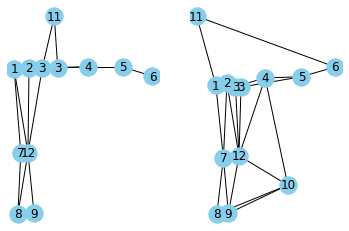

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2)

nx.draw(G_cad, pos_cad, node_color='skyblue', ax=ax1)
nx.draw_networkx_labels(G_cad, pos_cad, mapping_cad, ax=ax1)

nx.draw(G_net, pos_net, node_color='skyblue', ax=ax2)
nx.draw_networkx_labels(G_net, pos_net, mapping_net, ax=ax2)

plt.show()

#### Algoritmo per il match tra i grafi

In [11]:
th_dist = 0.3
th_score = 0.2

green_node = []
yellow_node = []
red_node = []

label_green_edge = []

max_score = {}

# ciclo su tutti i nodi del grafo CAD
for key_cad in mapping_cad:

    # check se esistono nel grafo INF nodi con la stessa label
    keys = [k for k, v in mapping_net.items() if v == mapping_cad[key_cad]]
    if keys:
        for key_inf in keys:

            # valuto la distanza euclidea tra il nodo del grafo CAD e il nodo del grafo INF con la stessa label
            dist = np.linalg.norm(pos_cad[key_cad] - pos_net[key_inf])
            if dist < th_dist:

                # definisco delle tuple di relazioni dei nodi per entrambi i grafi
                # schema @ (label_1, label_2, position)
                tuple_inf = [(tuple_inf[0], tuple_inf[2], tuple_inf[4]) for tuple_inf in neig_net if
                             (mapping_net[key_inf] in (tuple_inf[0], tuple_inf[2]))]
                tuple_gt = [(tuple_gt[0], tuple_gt[2], tuple_gt[4]) for tuple_gt in neig_cad if
                            (mapping_cad[key_cad] in (tuple_gt[0], tuple_gt[2]))]

                # verifico che nei due grafi siano presenti le stesse relazioni tra i nodi
                count = 0
                for t_inf in tuple_inf:
                    if t_inf in tuple_gt:
                        label_green_edge.append(t_inf)
                        count += 1

                # in base allo score assegno un nodo del grafo INF ad una classe
                score = count / len(tuple_gt)
                if score > th_score:
                    max_score[key_cad] = (key_inf, score)
                    green_node.append(key_cad)
                else:
                    yellow_node.append(key_cad)
            else:
                red_node.append(key_cad)
    else:
        red_node.append(key_cad)

green_node = removeDuplicates(green_node)
yellow_node = removeDuplicates(yellow_node)
red_node = removeDuplicates(red_node)

yellow_node, red_node = checkNodeClass(green_node, yellow_node, red_node, max_score)

In [13]:
# Definisco la correttezza delle relazioni tra i nodi nel grafo

# valutazione delle relazioni in base alla label
label_red_edge = []
for tpl in neig_cad:
    if (tpl[0], tpl[2], tpl[4]) not in label_green_edge:
        label_red_edge.append((tpl[0], tpl[2], tpl[4]))

# assegnazione di un colore agli archi del grafo in base all'id dei nodi del grafo CAD
green_edge = []
for lst1 in label_green_edge:
    for lst in neig_cad:
        if lst1[0] == lst[0] and lst1[1] == lst[2] and lst1[2] == lst[4]:
            green_edge.append((lst[1], lst[3]))

red_edge = []
for lst1 in label_red_edge:
    for lst in neig_cad:
        if lst1[0] == lst[0] and lst1[1] == lst[2] and lst1[2] == lst[4]:
            red_edge.append((lst[1], lst[3]))

green_edge = removeDuplicates(green_edge)
red_edge = removeDuplicates(red_edge)

#### Rappresentazione del grafo CAD colorato in base ai nodi e gli archi riconosciuti

{6: Text(0.0, 0.7345060928521878, '1'),
 8: Text(0.09990759990760001, 0.30890956924647583, '12'),
 10: Text(0.027046277046277156, 0.0, '8'),
 9: Text(0.04831754831754842, 0.30890956924647583, '7'),
 11: Text(0.10780010780010785, 0.7396892710828393, '2'),
 12: Text(0.14406714406714416, 0.002630855617073047, '9'),
 4: Text(0.20405020405020413, 0.7396892710828393, '3'),
 1: Text(0.29048279048279046, 1.0, '11'),
 5: Text(0.31493031493031487, 0.7396892710828393, '3'),
 2: Text(0.5368830368830368, 0.7434588552505859, '4'),
 3: Text(0.7852082852082853, 0.7434588552505859, '5'),
 7: Text(1.0000000000000002, 0.6963390531537546, '6')}

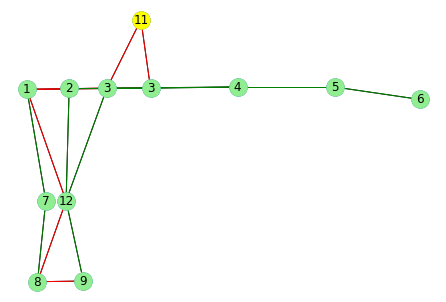

In [14]:
G_cad_col = nx.Graph()

G_cad_col.add_nodes_from(nodes_cad)
edge = [(lst[1], lst[3]) for lst in neig_cad]
G_cad_col.add_edges_from(edge)

# draw the graph
nx.draw(G_cad_col, pos_cad)

nx.draw_networkx_nodes(G_cad_col, pos_cad, nodelist=green_node, node_color="lightgreen")
nx.draw_networkx_nodes(G_cad_col, pos_cad, nodelist=yellow_node, node_color="yellow")
nx.draw_networkx_nodes(G_cad_col, pos_cad, nodelist=red_node, node_color="red")

nx.draw_networkx_edges(G_cad_col, pos_cad, edgelist=red_edge, edge_color="red")
nx.draw_networkx_edges(G_cad_col, pos_cad, edgelist=green_edge, edge_color="green")

nx.draw_networkx_labels(G_cad_col, pos_cad, mapping_cad)
# nx.draw_networkx_edge_labels(G_cad_col, pos_cad, edge_labels=edge_labels, font_color='skyblue')